In [1]:
import os
import shlex
import subprocess
from pathlib import Path

import essentia.standard as es
import ipywidgets as widgets
import matplotlib.pyplot as plt
import music21
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import stumpy
from dtwParallel import dtw_functions
from IPython.display import HTML, Audio, FileLinks, display
from ipywidgets import interact
from music21 import chord, converter, harmony, note
from plotly.subplots import make_subplots
from scipy.spatial import distance as d

import demucs.separate

In [2]:
corpus = '../Star-Wars-Thematic-Corpus/'

In [3]:
# List all files in the corpus directory
files = os.listdir(corpus)

# Print the files
print("Files in corpus:")
for file in files:
    print(f"- {file}")

# Optionally, print full paths
print("\nFull paths:")
for file in files:
    print(f"- {os.path.join(corpus, file)}")

Files in corpus:
- PrequelTriologyThemeFiles
- SequelTriologyThemeFiles
- .DS_Store
- OriginalTriologyThemeFiles
- readme.md
- StarWarsThemeCorpus.xlsx
- .gitignore
- Scripts
- .gitattributes

Full paths:
- ../Star-Wars-Thematic-Corpus/PrequelTriologyThemeFiles
- ../Star-Wars-Thematic-Corpus/SequelTriologyThemeFiles
- ../Star-Wars-Thematic-Corpus/.DS_Store
- ../Star-Wars-Thematic-Corpus/OriginalTriologyThemeFiles
- ../Star-Wars-Thematic-Corpus/readme.md
- ../Star-Wars-Thematic-Corpus/StarWarsThemeCorpus.xlsx
- ../Star-Wars-Thematic-Corpus/.gitignore
- ../Star-Wars-Thematic-Corpus/Scripts
- ../Star-Wars-Thematic-Corpus/.gitattributes


In [4]:
sample_file = '../Star-Wars-Thematic-Corpus/OriginalTriologyThemeFiles/Xmls/1a_Main_Theme_Basic_(A_Section).musicxml'
audio_file = '/Users/sid/Downloads/Torrents/Music/John Williams & London Symphony Orchestra - Star Wars - The Ultimate Digital Collection (2016 - Soundtracks) [Flac 24-44_192]/46. John Williams & London Symphony Orchestra - Episode IV - Main Title.flac'
audio_file_2 = "/Users/sid/Downloads/Torrents/Music/John Williams & London Symphony Orchestra - Star Wars - The Ultimate Digital Collection (2016 - Soundtracks) [Flac 24-44_192]/45. John Williams, London Symphony Orchestra & London Voices - Episode III - A New Hope and End Credits.flac"

In [5]:
# # Assume that your command is `demucs --mp3 --two-stems vocals -n mdx_extra "track with space.mp3"`
# # The following codes are same as the command above:
# demucs.separate.main(["--mp3", "--two-stems", "vocals", "-n", "mdx_extra", "track with space.mp3"])

# demucs.separate.main(shlex.split('--mp3 --two-stems vocals -n mdx_extra "track with space.mp3"'))

In [6]:
# demucs.separate.main(["--mp3", "-n", "htdemucs", "-d", "mps",  audio_file])

Average pitch: 350.4535217285156 Hz
Min pitch: 81.93245697021484 Hz
Max pitch: 948.6402587890625 Hz


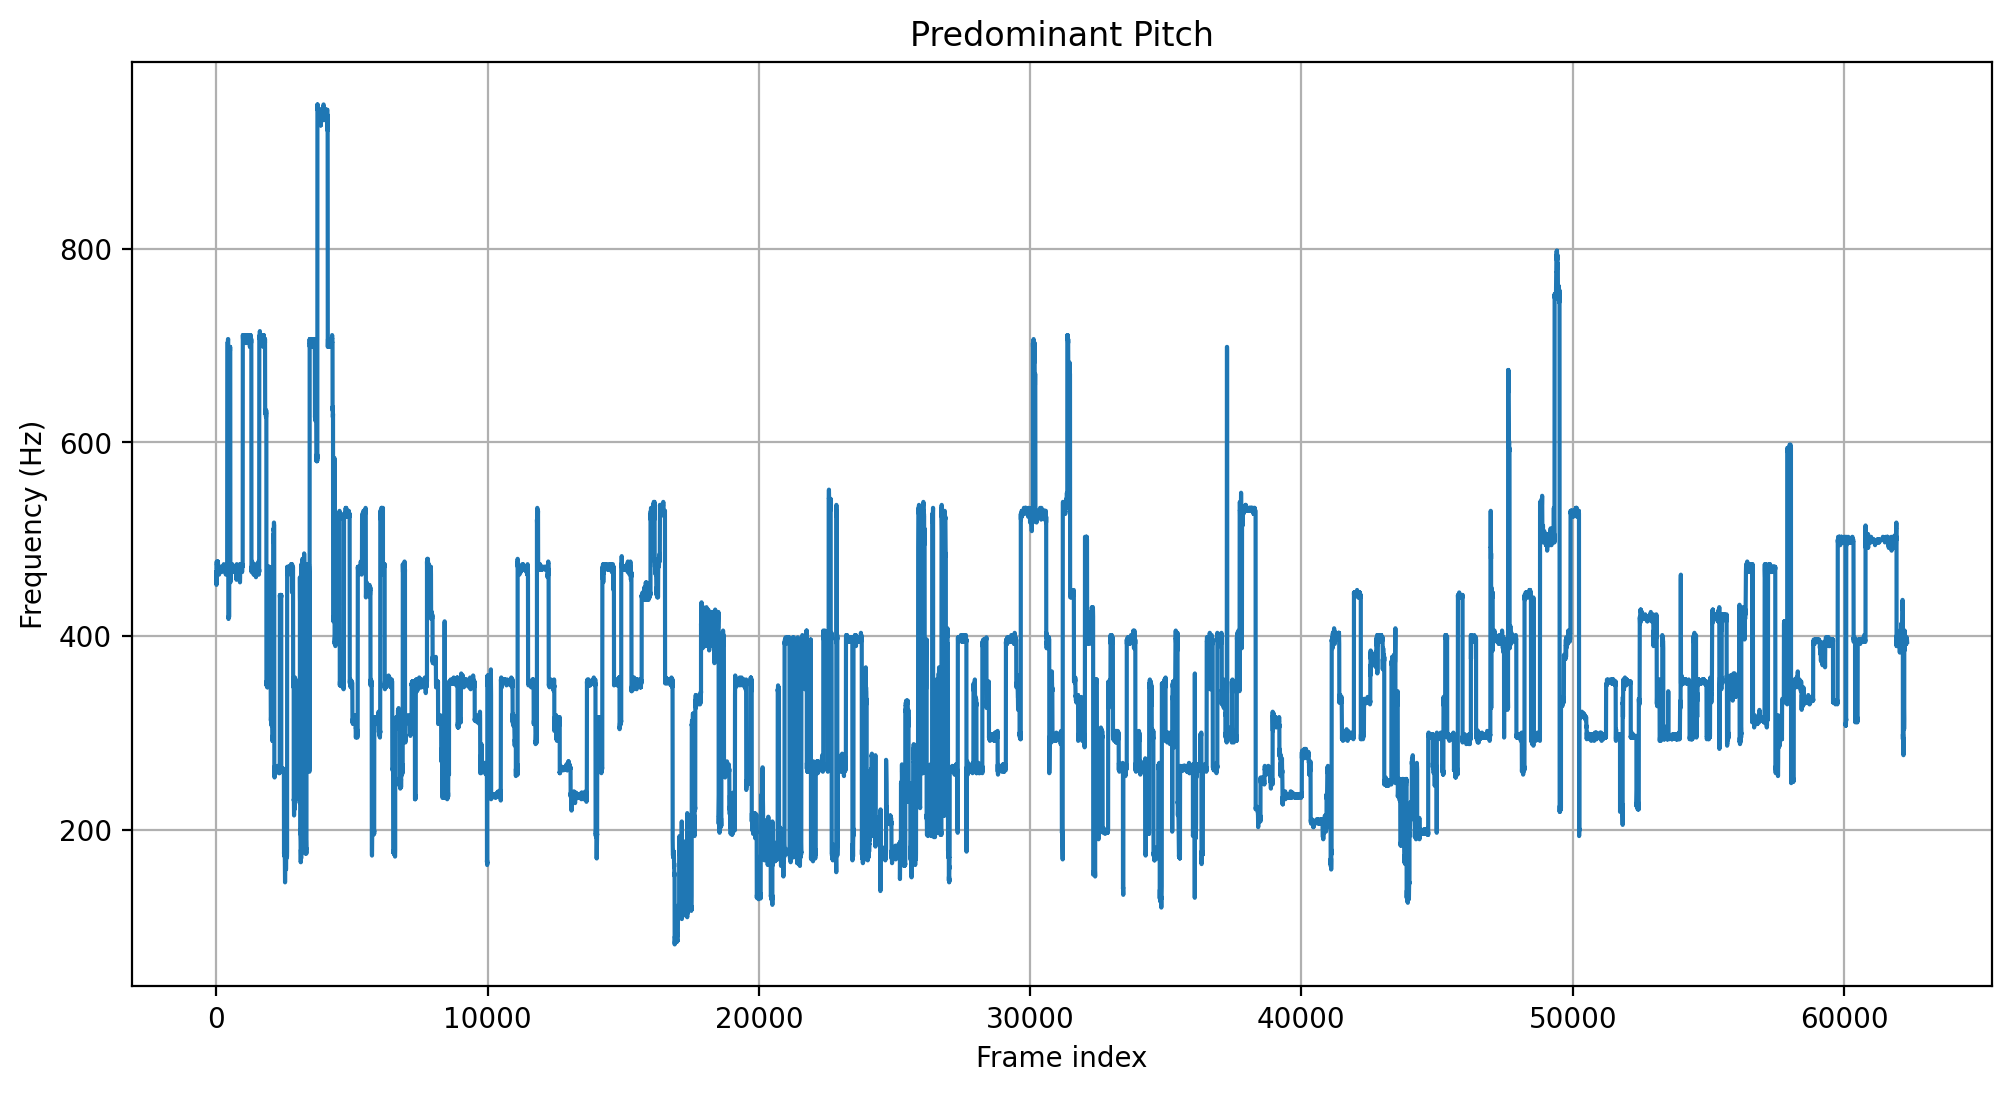

In [9]:
# If audio file exists, use Essentia's PredominantPitchMelodia
audio = es.MonoLoader(filename=audio_file)()

# Extract predominant pitch
pitch_extractor = es.PredominantPitchMelodia()
predominant_pitch, pitch_confidence = pitch_extractor(audio)

# Filter out zero pitch values (unvoiced frames)
valid_pitch = predominant_pitch[predominant_pitch > 0]

# Plot the predominant pitch
plt.figure(figsize=(12, 6))
plt.plot(valid_pitch)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Frame index')
plt.title('Predominant Pitch')
plt.grid(True)

print(f"Average pitch: {valid_pitch.mean()} Hz")
print(f"Min pitch: {valid_pitch.min()} Hz")
print(f"Max pitch: {valid_pitch.max()} Hz")

Average pitch: 370.52 Hz
Min pitch: 105.64 Hz
Max pitch: 1064.81 Hz
Most prominent pitch classes: [10  3  8]


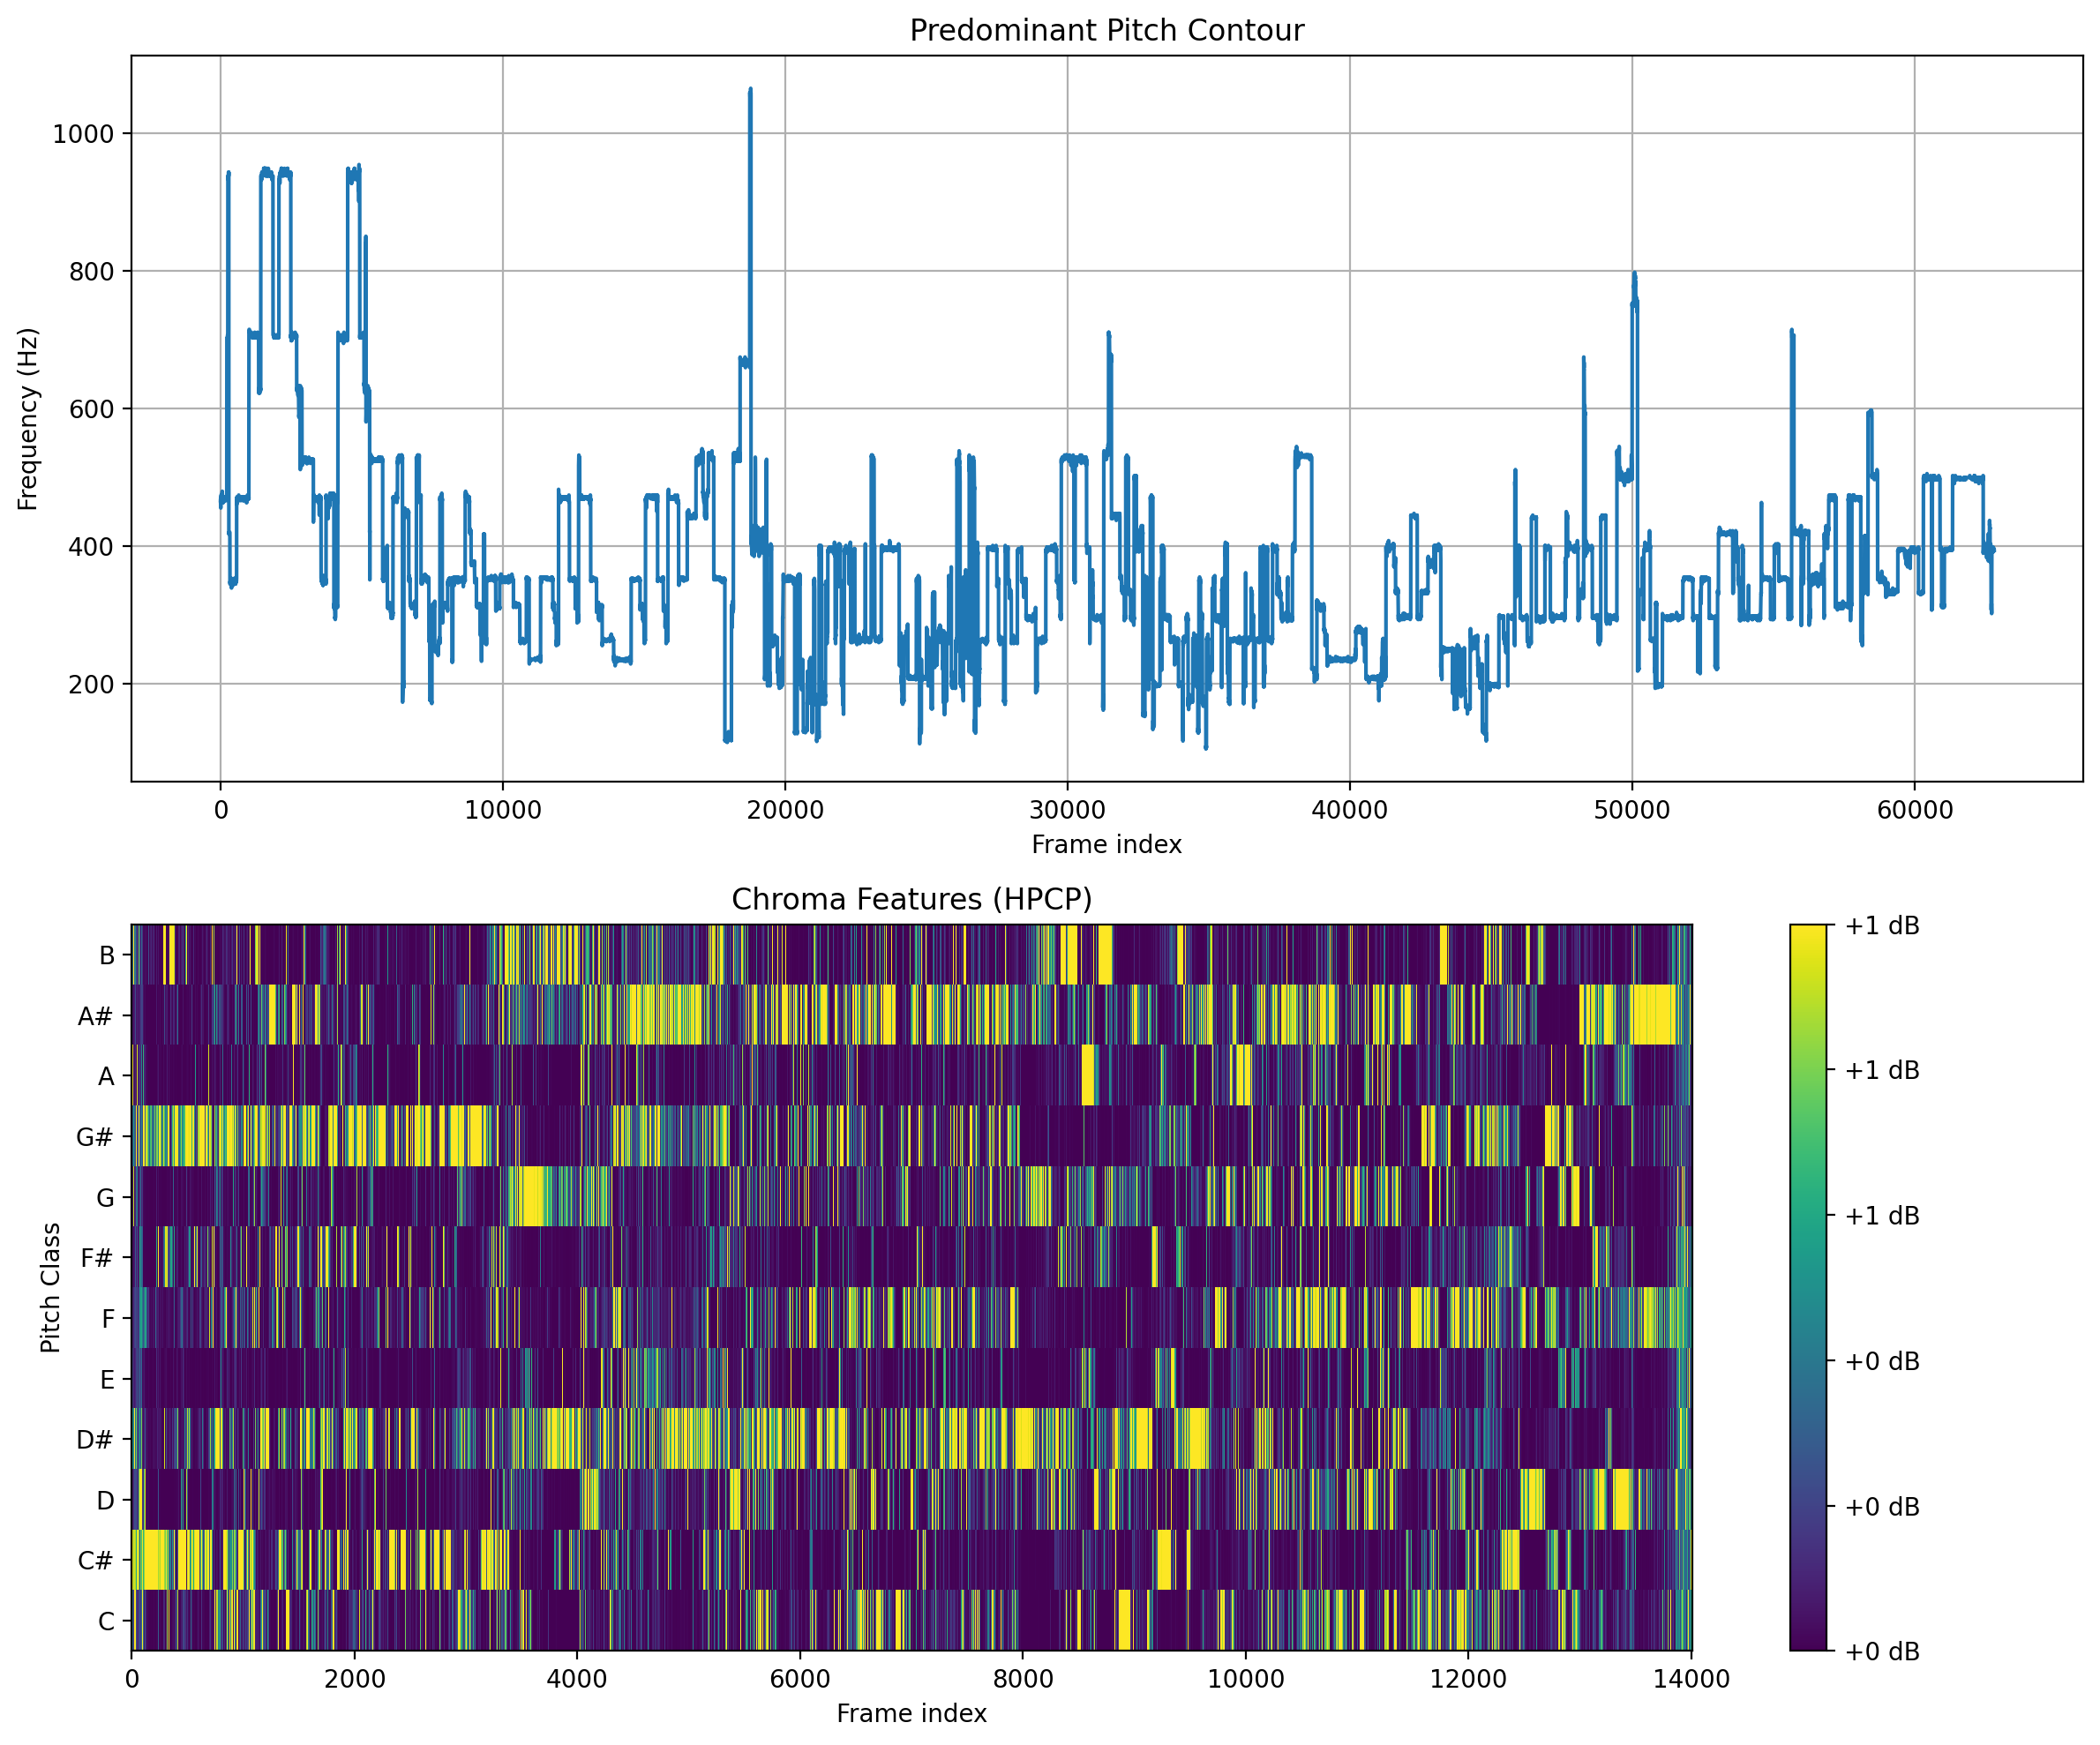

In [10]:
# Load the separated instrumental track
audio = es.MonoLoader(filename='separated/htdemucs/46. John Williams & London Symphony Orchestra - Episode IV - Main Title/other.mp3')()

# 1. Extract predominant pitch (melody)
pitch_extractor = es.PredominantPitchMelodia()
predominant_pitch, pitch_confidence = pitch_extractor(audio)

# Filter out zero pitch values (unvoiced frames)
valid_pitch = predominant_pitch[predominant_pitch > 0]

# 2. Extract chroma features (harmonic content)
# First, compute the spectrum
window = es.Windowing(type='hann')
spectrum = es.Spectrum()
spectral_peaks = es.SpectralPeaks(orderBy='magnitude')
hpcp = es.HPCP()  # Harmonic Pitch Class Profile (chroma)

# Process the audio in frames to get chroma
frame_size = 2048
hop_size = 1024
chroma_data = []

for frame in es.FrameGenerator(audio, frameSize=frame_size, hopSize=hop_size):
    windowed_frame = window(frame)
    spec = spectrum(windowed_frame)
    peaks_freqs, peaks_mags = spectral_peaks(spec)
    chroma_vector = hpcp(peaks_freqs, peaks_mags)
    chroma_data.append(chroma_vector)

chroma_data = np.array(chroma_data)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot pitch contour
ax1.plot(valid_pitch)
ax1.set_ylabel('Frequency (Hz)')
ax1.set_xlabel('Frame index')
ax1.set_title('Predominant Pitch Contour')
ax1.grid(True)

# Plot chroma features as a spectrogram
im = ax2.imshow(chroma_data.T, aspect='auto', origin='lower', 
                interpolation='nearest', cmap='viridis')
ax2.set_ylabel('Pitch Class')
ax2.set_yticks(range(12))
ax2.set_yticklabels(['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'])
ax2.set_xlabel('Frame index')
ax2.set_title('Chroma Features (HPCP)')
plt.colorbar(im, ax=ax2, format='%+2.0f dB')

plt.tight_layout()

# Print pitch statistics
print(f"Average pitch: {valid_pitch.mean():.2f} Hz")
print(f"Min pitch: {valid_pitch.min():.2f} Hz")
print(f"Max pitch: {valid_pitch.max():.2f} Hz")

# Analyze chroma to identify predominant keys
mean_chroma = np.mean(chroma_data, axis=0)
print(f"Most prominent pitch classes: {np.argsort(mean_chroma)[::-1][:3]}")

In [11]:

score = converter.parse(sample_file)

# Initialize an empty list for MIDI notes
notes = []

# Iterate through elements in the score
for element in score.flatten().notes:
    # Handle different types of elements
    if isinstance(element, note.Note):
        # Regular note with pitch
        notes.append(element.pitch.midi)
    elif isinstance(element, chord.Chord):
        # Chord with multiple pitches
        for pitch in element.pitches:
            notes.append(pitch.midi)
    elif isinstance(element, harmony.ChordSymbol):
        # Skip ChordSymbol objects
        continue

# Print the first few notes to check
print(f"Extracted {len(notes)} MIDI notes, first 10: {notes[:10] if notes else []}")

Extracted 122 MIDI notes, first 10: [53, 57, 60, 65, 65, 65, 46, 50, 53, 70]


Prepared time series with 45 notes for pattern matching


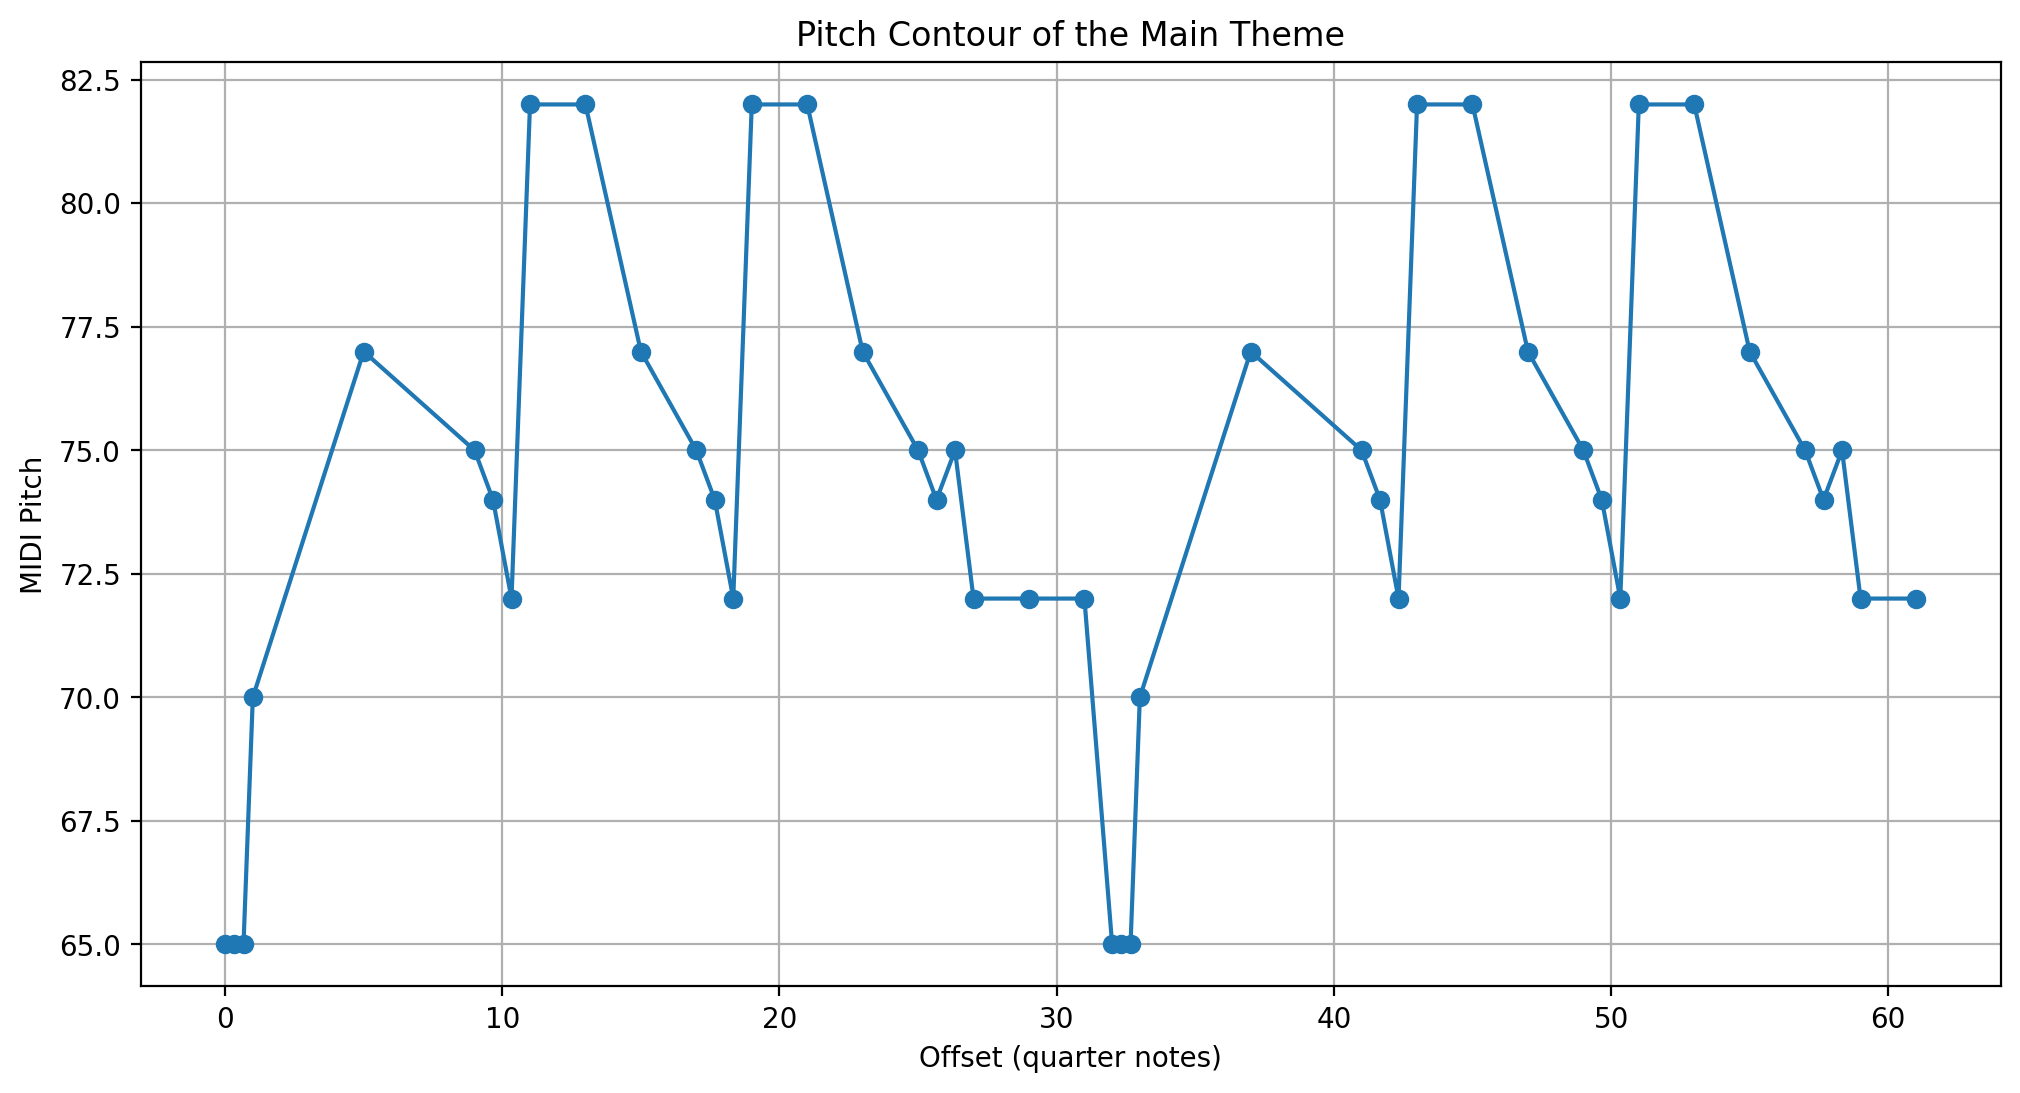

In [12]:
# We need to re-process the score to include duration information
notes_with_duration = []

for element in score.flatten().notes:
    if isinstance(element, note.Note):
        # Store pitch and duration as tuple
        notes_with_duration.append({
            'pitch': element.pitch.midi,
            'duration': element.duration.quarterLength,
            'offset': element.offset
        })
    # Skip chords completely - don't process chord pitches

# Convert to dataframe for easier manipulation
notes_df = pd.DataFrame(notes_with_duration)

# Plot the pitch contour
plt.figure(figsize=(12, 6))
plt.plot(notes_df['offset'], notes_df['pitch'], 'o-')
plt.xlabel('Offset (quarter notes)')
plt.ylabel('MIDI Pitch')
plt.title('Pitch Contour of the Main Theme')
plt.grid(True)

# Prepare the time series for pattern matching with stumpy
# First, ensure we have pitch values in chronological order
time_series = notes_df.sort_values('offset')[['pitch']]

print(f"Prepared time series with {len(time_series)} notes for pattern matching")


In [13]:
# Convert frequency values in Hz to MIDI pitch
def hz_to_midi(frequency):
    return 69 + 12 * np.log2(frequency / 440)

# Helper function for pattern matching with adjustable parameters
def find_pattern_matches(pattern, time_series, distance_threshold_multiplier=1.2, 
                         min_confidence=0.7, max_matches=50, use_duration=False):
    # Extract the pitch values
    pattern = time_series['pitch'].values
    
    # Convert valid_pitch to MIDI values
    midi_pitch = hz_to_midi(valid_pitch)

    best_match_idx = 0
    best_distance = float('inf')
    best_transpose = 0

    for transpose in range(-12, 13):  # Try transpositions from -12 to +12 semitones
        # Transpose the pattern
        pattern_transposed = pattern + transpose
        
        # Normalize both time series for better comparison
        pattern_normalized = (pattern_transposed - np.mean(pattern_transposed)) / np.std(pattern_transposed)
        midi_pitch_normalized = (midi_pitch - np.mean(midi_pitch)) / np.std(midi_pitch)
        
        # Convert to float64 to avoid TypeError from stumpy
        pattern_normalized = pattern_normalized.astype(np.float64)
        midi_pitch_normalized = midi_pitch_normalized.astype(np.float64)
        
        # Use stumpy to find where pattern appears in the longer time series
        distances = stumpy.mass(pattern_normalized, midi_pitch_normalized)
        
        # Check if this transposition gives a better match
        min_dist = np.min(distances)
        if min_dist < best_distance:
            best_distance = min_dist
            best_match_idx = np.argmin(distances)
            best_transpose = transpose
            best_distances = distances

    # Set threshold based on parameter
    distance_threshold = best_distance * distance_threshold_multiplier
    
    # Find all occurrences below the threshold
    match_indices = np.where(best_distances < distance_threshold)[0]
    
    # Filter out matches that are too close to each other (within pattern length)
    filtered_match_indices = []
    for i, idx in enumerate(match_indices):
        if i == 0 or idx - filtered_match_indices[-1] >= len(pattern):
            # Apply confidence filtering if pitch_confidence data is available
            if 'pitch_confidence' in locals() and np.mean(pitch_confidence[idx:idx+len(pattern)]) < min_confidence:
                continue
            filtered_match_indices.append(idx)
            
            # Limit to max_matches
            if len(filtered_match_indices) >= max_matches:
                break
    
    return filtered_match_indices, best_match_idx, best_distance, best_transpose, best_distances

# Convert valid_pitch to MIDI values
midi_pitch = hz_to_midi(valid_pitch)

# Extract the pitch values from time_series DataFrame to a numpy array
pattern = time_series['pitch'].values

# Create interactive widgets
@interact
def analyze_pattern(threshold_multiplier=(1.0, 2.0, 0.1), 
                   min_confidence=(0.7, 1.0, 0.1), 
                   max_matches=(10, 500, 10),
                   use_duration=False):
    
    # Find matches with user parameters
    filtered_match_indices, best_match_idx, best_distance, best_transpose, best_distances = find_pattern_matches(
        pattern, time_series, threshold_multiplier, min_confidence, max_matches, use_duration
    )
    
    print(f"Best match found at index {best_match_idx} with distance {best_distance:.4f}")
    print(f"Best transpose value: {best_transpose} semitones")
    print(f"Found {len(filtered_match_indices)} occurrences of the pattern")
    
    # Use the hop_size from the variables
    time_per_frame = hop_size / 44100  # seconds per frame

    # Convert frame indices to timestamps
    def frame_to_time(frame_idx):
        return frame_idx * time_per_frame

    # Create dataframe with match information
    match_info = []
    for i, idx in enumerate(filtered_match_indices[:max_matches]):
        start_time = frame_to_time(idx)
        end_time = frame_to_time(idx + len(pattern))
        match_info.append({
            'Match #': i+1,
            'Start Time (s)': f"{start_time:.2f}",
            'End Time (s)': f"{end_time:.2f}",
            'Distance': f"{best_distances[idx]:.4f}"
        })
        
    match_df = pd.DataFrame(match_info)
    display(match_df)
    
    # Create 5 subplots
    fig = make_subplots(rows=5, cols=1, 
                        subplot_titles=('Original Pattern (from MusicXML)', 
                                        f'Transposed Pattern ({best_transpose} semitones)',
                                        'Best Matching Segment (from Audio)',
                                        'All Matching Segments (Overlaid)',
                                        'Full Audio Pitch with All Matches Highlighted'))

    # Plot 1: Original pattern from score
    fig.add_trace(
        go.Scatter(y=pattern, mode='lines', name='Original Pattern'),
        row=1, col=1
    )

    # Plot 2: Transposed pattern
    fig.add_trace(
        go.Scatter(y=pattern + best_transpose, mode='lines', name='Transposed Pattern'),
        row=2, col=1
    )

    # Plot 3: Best matching segment from audio pitch with timestamps
    match_end = best_match_idx + len(pattern)
    match_times = [frame_to_time(i) for i in range(best_match_idx, match_end)]
    fig.add_trace(
        go.Scatter(x=match_times, 
                   y=midi_pitch[best_match_idx:match_end], 
                   mode='lines', 
                   name='Best Match'),
        row=3, col=1
    )

    # Plot 4: All matches overlaid on the same time axis
    colors = px.colors.qualitative.Plotly[:len(filtered_match_indices)] if len(filtered_match_indices) <= 10 else [
        px.colors.qualitative.Plotly[i % len(px.colors.qualitative.Plotly)] 
        for i in range(min(len(filtered_match_indices), max_matches))
    ]

    for i, idx in enumerate(filtered_match_indices[:max_matches]):
        match_end = idx + len(pattern)
        match_times = [frame_to_time(j) for j in range(idx, match_end)]
        fig.add_trace(
            go.Scatter(x=match_times, 
                       y=midi_pitch[idx:match_end], 
                       mode='lines', 
                       name=f'Match {i+1} (t={frame_to_time(idx):.1f}s)',
                       line=dict(color=colors[i])),
            row=4, col=1
        )

    # Plot 5: Full audio pitch with all matches highlighted
    all_times = [frame_to_time(i) for i in range(len(midi_pitch))]
    fig.add_trace(
        go.Scatter(x=all_times, 
                   y=midi_pitch, 
                   mode='lines', 
                   opacity=0.5, 
                   name='Full Audio Pitch'),
        row=5, col=1
    )

    for i, idx in enumerate(filtered_match_indices[:max_matches]):
        match_end = idx + len(pattern)
        match_times = [frame_to_time(j) for j in range(idx, match_end)]
        fig.add_trace(
            go.Scatter(x=match_times, 
                       y=midi_pitch[idx:match_end], 
                       mode='lines', 
                       line=dict(color=colors[i]), 
                       name=f'Match {i+1}'),
            row=5, col=1
        )

    # Update layout
    fig.update_layout(height=1000, width=900, 
                      showlegend=True,
                      title_text="Pattern Matching Results")

    # Update y-axes labels
    for i in range(1, 6):
        fig.update_yaxes(title_text="MIDI pitch", row=i, col=1)
        
    # Update x-axis labels
    fig.update_xaxes(title_text="Note Index", row=1, col=1)
    fig.update_xaxes(title_text="Note Index", row=2, col=1)
    fig.update_xaxes(title_text="Time (seconds)", row=3, col=1)
    fig.update_xaxes(title_text="Time (seconds)", row=4, col=1)
    fig.update_xaxes(title_text="Time (seconds)", row=5, col=1)

    fig.show()

    # Create audio players for a sample of matches
    print("Listen to sample matched segments:")
    for i, idx in enumerate(filtered_match_indices):  # Only show first 5 audio samples
        start_sample = int(frame_to_time(idx) * 44100)
        end_sample = int(frame_to_time(idx + len(pattern)) * 44100)
        
        # Add some context before and after (1 second)
        context = 44100
        start_sample = max(0, start_sample - context)
        end_sample = min(len(audio), end_sample + context)
        
        # Create audio clip
        audio_segment = audio[start_sample:end_sample]
        
        # Display audio player with label
        display(HTML(f"<b>Match {i+1} (t={frame_to_time(idx):.1f}s):</b>"))
        display(Audio(data=audio_segment, rate=44100))


interactive(children=(FloatSlider(value=1.5, description='threshold_multiplier', max=2.0, min=1.0), FloatSlide…

# DTW

In [ ]:
import os

import essentia.standard as es
import music21
import numpy as np
import plotly.graph_objects as go
import stumpy
from dtwParallel import dtw_functions
from IPython.display import HTML, Audio, display
from plotly.subplots import make_subplots
from scipy.spatial import distance as d

# 1. First, perform source separation on audio_file_2 if not already done
if not os.path.exists(f'separated/htdemucs/45. John Williams, London Symphony Orchestra & London Voices - Episode III - A New Hope and End Credits/other.mp3'):
    print("Performing source separation on second audio file...")
    demucs.separate.main(["--mp3", "-n", "htdemucs", "-d", "mps", audio_file_2])
else:
    print("Source separation already done for second audio file.")

# 2. Load both separated audio files
audio_1 = es.MonoLoader(filename='separated/htdemucs/46. John Williams & London Symphony Orchestra - Episode IV - Main Title/other.mp3')()
audio_2 = es.MonoLoader(filename='separated/htdemucs/45. John Williams, London Symphony Orchestra & London Voices - Episode III - A New Hope and End Credits/other.mp3')()

# 3. Extract pitch contours from both files
print("Extracting pitch contours...")
pitch_extractor = es.PredominantPitchMelodia(hopSize=512, minFrequency=80, maxFrequency=1000)  
pitch_1, conf_1 = pitch_extractor(audio_1)
pitch_2, conf_2 = pitch_extractor(audio_2)

# Filter out zero pitch values and low confidence
valid_mask_1 = (pitch_1 > 0) & (conf_1 > 0.5)
valid_mask_2 = (pitch_2 > 0) & (conf_2 > 0.5)

valid_pitch_1 = pitch_1[valid_mask_1]
valid_pitch_2 = pitch_2[valid_mask_2]

print(f"Valid pitch points in file 1: {len(valid_pitch_1)}")
print(f"Valid pitch points in file 2: {len(valid_pitch_2)}")

# Handle case where there are not enough valid pitch points
if len(valid_pitch_1) < 10 or len(valid_pitch_2) < 10:
    print("Not enough valid pitch points found. Try adjusting parameters.")
    valid_mask_1 = (pitch_1 > 0)
    valid_mask_2 = (pitch_2 > 0)
    valid_pitch_1 = pitch_1[valid_mask_1]
    valid_pitch_2 = pitch_2[valid_mask_2]
    print(f"Using minimal filtering. Points in file 1: {len(valid_pitch_1)}, file 2: {len(valid_pitch_2)}")

# 4. Apply smoothing
def smooth_array(arr, window_size=5):
    if len(arr) < window_size:
        return arr
    return np.convolve(arr, np.ones(window_size)/window_size, mode='valid')

smooth_pitch_1 = smooth_array(valid_pitch_1, 5) if len(valid_pitch_1) >= 5 else valid_pitch_1
smooth_pitch_2 = smooth_array(valid_pitch_2, 5) if len(valid_pitch_2) >= 5 else valid_pitch_2

# 5. Normalize the pitch contours
def normalize_array(arr):
    if len(arr) == 0:
        return arr
    return (arr - np.mean(arr)) / (np.std(arr) or 1)

norm_pitch_1 = normalize_array(smooth_pitch_1)
norm_pitch_2 = normalize_array(smooth_pitch_2)

# 6. Use the XML-derived pattern as ground truth
# Load the MusicXML file if not already loaded
if 'pattern' not in globals() or pattern is None:
    print("Loading pattern from MusicXML file...")
    sample_file = '../Star-Wars-Thematic-Corpus/OriginalTriologyThemeFiles/Xmls/1a_Main_Theme_Basic_(A_Section).musicxml'
    score = music21.converter.parse(sample_file)
    pattern = np.array([n.pitch.midi for n in score.flat.notes])
    print(f"Extracted pattern of {len(pattern)} notes from MusicXML")
else:
    print(f"Using existing pattern with {len(pattern)} notes")

# 7. Convert pattern to a normalized contour for comparison
# Creating a simple step function representation of the pattern
def pattern_to_contour(midi_pattern, length=100):
    # Create a simplified contour from the MIDI pattern
    contour = np.zeros(length)
    step_size = length / len(midi_pattern)
    for i, note in enumerate(midi_pattern):
        start_idx = int(i * step_size)
        end_idx = int((i + 1) * step_size)
        contour[start_idx:end_idx] = note
    return normalize_array(contour)

pattern_contour = pattern_to_contour(pattern)
window_size = len(pattern_contour)

# 8. Find matches using sliding window DTW comparison
print(f"Searching for pattern matches in audio files using DTW...")

def find_pattern_matches(norm_pitch, pattern_contour, top_n=10, step_size=20):
    matches = []
    for i in range(0, len(norm_pitch) - window_size, step_size):
        segment = norm_pitch[i:i+window_size]
        if len(segment) == len(pattern_contour):
            # Use the same DTW function as before
            dist = dtw_functions.dtw(
                segment.tolist(),
                pattern_contour.tolist(),
                local_dissimilarity=d.euclidean
            )
            matches.append((i, dist))
    
    # Sort by distance (lower is better)
    matches.sort(key=lambda x: x[1])
    return matches[:top_n]

# Find top matches in both audio files
matches_1 = find_pattern_matches(norm_pitch_1, pattern_contour)
matches_2 = find_pattern_matches(norm_pitch_2, pattern_contour)

print(f"Found {len(matches_1)} matches in file 1")
print(f"Found {len(matches_2)} matches in file 2")

# 9. Visualize the results
if matches_1 and matches_2:
    num_to_show = min(5, len(matches_1), len(matches_2))
    fig = make_subplots(rows=num_to_show, cols=2,
                        subplot_titles=[f"File 1 - Match {i+1}: Score={match[1]:.6f}"
                                       for i, match in enumerate(matches_1[:num_to_show])] +
                                      [f"File 2 - Match {i+1}: Score={match[1]:.6f}"
                                       for i, match in enumerate(matches_2[:num_to_show])])

    # Add ground truth pattern at the top
    # Create a time axis for the pattern
    t_pattern = np.linspace(0, 1, len(pattern_contour))
    
    for i in range(num_to_show):
        idx1, dist1 = matches_1[i]
        idx2, dist2 = matches_2[i]
        
        sr = 44100
        hop_size = 512
        time1 = idx1 * hop_size / sr
        time2 = idx2 * hop_size / sr
        
        segment1 = norm_pitch_1[idx1:idx1+window_size]
        segment2 = norm_pitch_2[idx2:idx2+window_size]
        
        t1 = np.linspace(time1, time1 + (window_size * hop_size / sr), len(segment1))
        t2 = np.linspace(time2, time2 + (window_size * hop_size / sr), len(segment2))
        
        # Plot file 1 matches
        fig.add_trace(
            go.Scatter(x=t1, y=segment1, mode='lines', name=f'File 1 segment'),
            row=i+1, col=1
        )
        fig.add_trace(
            go.Scatter(x=t1, y=pattern_contour, mode='lines', name=f'Ground Truth Pattern', line=dict(dash='dash')),
            row=i+1, col=1
        )
        
        # Plot file 2 matches
        fig.add_trace(
            go.Scatter(x=t2, y=segment2, mode='lines', name=f'File 2 segment'),
            row=i+1, col=2
        )
        fig.add_trace(
            go.Scatter(x=t2, y=pattern_contour, mode='lines', name=f'Ground Truth Pattern', line=dict(dash='dash')),
            row=i+1, col=2
        )
        
        fig.update_xaxes(title_text="Time (s)", row=i+1, col=1)
        fig.update_xaxes(title_text="Time (s)", row=i+1, col=2)
        fig.update_yaxes(title_text="Normalized Pitch", row=i+1, col=1)
        fig.update_yaxes(title_text="Normalized Pitch", row=i+1, col=2)

    fig.update_layout(height=1200, width=1200, title_text="Top Melodic Pattern Matches Compared to Ground Truth")
    fig.show()

    # 10. Play audio segments of the matches
    print("Listen to the matched segments:")
    
    # Add buffer before and after the match for better context
    buffer_seconds = 1
    buffer_samples = buffer_seconds * sr
    
    for i in range(num_to_show):
        idx1, dist1 = matches_1[i]
        idx2, dist2 = matches_2[i]
        
        start_sample1 = max(0, idx1 * hop_size - buffer_samples)
        start_sample2 = max(0, idx2 * hop_size - buffer_samples)
        duration_samples = (3 + 2 * buffer_seconds) * sr  # 3 seconds for the match + buffer before and after
        end_sample1 = min(len(audio_1), start_sample1 + duration_samples)
        end_sample2 = min(len(audio_2), start_sample2 + duration_samples)
        
        audio_segment1 = audio_1[start_sample1:end_sample1]
        audio_segment2 = audio_2[start_sample2:end_sample2]
        
        display(HTML(f"<h3>Pattern Match {i+1}</h3>"))
        display(HTML("<p>File 1 segment (distance = {:.6f}):</p>".format(dist1)))
        display(Audio(data=audio_segment1, rate=sr))
        display(HTML("<p>File 2 segment (distance = {:.6f}):</p>".format(dist2)))
        display(Audio(data=audio_segment2, rate=sr))
else:
    print("No matches found.")

Source separation already done for second audio file.
Extracting pitch contours...
Valid pitch points in file 1: 0
Valid pitch points in file 2: 0
Not enough valid pitch points found. Try adjusting parameters.
Using minimal filtering. Points in file 1: 19866, file 2: 43304
Using existing pattern with 45 notes
Searching for pattern matches in audio files using DTW...
Found 10 matches in file 1
Found 10 matches in file 2


Listen to the matched segments:
